In [1]:

import torch
import torch.utils.data
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

import chess
from network import ChessBoardEvalNN
from data.dataset import ChessPositionsDataset
from data.database import Database

import data.database

%load_ext autoreload
# %load_ext line_profiler
%autoreload 2

The following converts a number games from the specified pgn file to the individual positions.
The positions will be one hot encoded and stored in the database.

For each type of piece a 8x8 matrix is used and if a respective piece is located on a square it is assigned a 1 and else 0.
Due to sparsity we store this data in sparse format by only storing indicies.
All positions are mirrored to be from the perspective of the white player as this makes training easier for the DNN as it only has to learn to play from one perspective.

We only extract the games which where annotated by a engine before as this takes a lot of computational ressources to do.
We normalize and translate the scores into an interval from -1 and 1 (where 1 indicates an advantage for black and 1 for white).


We keep track (by hashing) which games already are stored and therefore dont allow them to be processed and stored multiple times.

NOTE: This process takes a lot of time (on my device ~1h per 100_000 games).

In [ ]:
with Database() as db:
    db.store_positions_from_pgn_file("./data/pgn/comp-2019-03.pgn", num_games = 300_000)

Let's check how many different games we have currently stored and how many positions they contain.

-> we make sure every position is only stored once as well

In [2]:


with Database() as db:
    count = db.cur.execute("SELECT COUNT(*) FROM games").fetchone()[0]
    print(f"{count} games stored")
    count = db.cur.execute("SELECT COUNT(*) FROM positions").fetchone()[0]
    print(f"{count} positions stored")


204113 games stored


So now lets create a Dataset to be used for training.

The ChessPostionsDataset accesses the SQLite database in a dynamic (load as you use) and therefore the memory consumption on the GPU for training is managable.

In [2]:
dataset = ChessPositionsDataset(num_positions = 8_414_441)

# maybe inspect how one dataelement looks like
# print(dataset[0])

Now we split our data into different sets.

In [3]:
val_set, train_set = torch.utils.data.random_split(dataset, [414_441, 8_000_000], generator=torch.Generator().manual_seed(42))

Take a look how the evalutations are distributed. Looks like a normal distribution. Nice

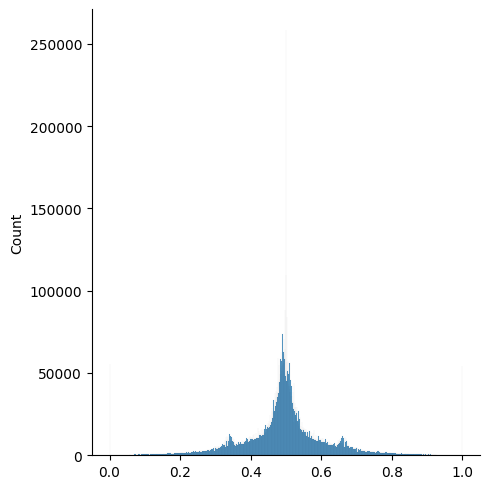

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.displot(dataset.get_all_evaluations())

Now we define our training process and our model.

We use PyTorch Lightning as it eases up the whole process and makes it less complicated.

We also log the whole process with TensorBoard to better understand whats going on.

In [10]:
import multiprocessing


hparams = {"learning_rate": 1e-3}

# create a new model
model : ChessBoardEvalNN = ChessBoardEvalNN(hparams=hparams)

# OR: import a previous version already trained some weights) of the model
# model = ChessBoardEvalNN.load_model(hparams)

logger = TensorBoardLogger("./tb_logs", name="ChessNN", default_hp_metric=False, log_graph=True)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else None,
    logger = logger,
    log_every_n_steps=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Now start fitting our model to the data on see how it performs.

In [11]:
train_dataloader = DataLoader(train_set, batch_size=1024, num_workers=multiprocessing.cpu_count(), shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1024, num_workers=multiprocessing.cpu_count())

trainer.fit(model, train_dataloader, val_dataloader)

Missing logger folder: ./tb_logs/ChessNN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | In sizes      | Out sizes
----------------------------------------------------------------------------
0 | intake        | Sequential    | 0      | [1, 12, 8, 8] | [1, 768] 
1 | residual_1    | ResidualBlock | 1.2 M  | [1, 768]      | [1, 768] 
2 | residual_2    | ResidualBlock | 1.2 M  | [1, 768]      | [1, 768] 
3 | residual_3    | ResidualBlock | 1.2 M  | [1, 768]      | [1, 768] 
4 | residual_4    | ResidualBlock | 1.2 M  | [1, 768]      | [1, 768] 
5 | exhaust_score | Sequential    | 429 K  | [1, 768]      | [1, 1]   
----------------------------------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.665    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):

  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutd

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>

AssertionErrorTraceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
:     self._shutdown_workers()can only test a c

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Exception ignored in: Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        self._shutdown_workers()    
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():if w.is_alive():

  File "/home/volk

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>    
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutd

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Traceback (most recent call last):

  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/pyth

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutd

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/volk/.cache/pypoetr

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>if w.is_alive():

  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
AssertionError
: can only test a 

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/pytho

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutd

Validation: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
  File "/home/volk/anaconda3/lib/py

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtuale

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>if w.is_alive():


Traceback (most recent call last):
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
      File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'ca

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: if w.is_alive():  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>Exception ignored in:   File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProces

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    if w.is_alive():

  File "/home/volk

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

  File "/home/volk/.cache/pypoet

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()if w.is_alive():
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/volk/anaconda3/lib/py

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutd

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
      File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():    self._shutdown_workers()
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>  File "/home/v

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>
Traceback (most recent call last):
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/volk/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbfa7a6a670>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/home/volk/.cache/pypoetry/virtualenvs/chessai-9CBJxCkL-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
:     can only test a child processself._shutdo

In [16]:

for i in range(0, 200):
    board, target_id, evaluation = dataset[i]
    board = board.to(model.device)
    board = board[None, :]
    model.eval()
    score = model.forward(board)
    print(f"truth eval: {evaluation}")
    print(f"predicted eval: {score}")

model.save_model("models/model1.model")

truth eval: 0.5211960673332214
predicted eval: 0.48836997151374817
truth eval: 0.5235960483551025
predicted eval: 0.4999273419380188
truth eval: 0.519196093082428
predicted eval: 0.48726126551628113
truth eval: 0.47999608516693115
predicted eval: 0.49086472392082214
truth eval: 0.48319607973098755
predicted eval: 0.5002878308296204
truth eval: 0.47339609265327454
predicted eval: 0.5033338069915771
truth eval: 0.4893960952758789
predicted eval: 0.500287652015686
truth eval: 0.49039608240127563
predicted eval: 0.5000424981117249
truth eval: 0.49619609117507935
predicted eval: 0.5002878308296204
truth eval: 0.49459609389305115
predicted eval: 0.49650272727012634
truth eval: 0.4909960925579071
predicted eval: 0.5002878308296204
truth eval: 0.4615961015224457
predicted eval: 0.5135619640350342
truth eval: 0.4591961205005646
predicted eval: 0.5002709031105042
truth eval: 0.45819610357284546
predicted eval: 0.5549513697624207
truth eval: 0.47499608993530273
predicted eval: 0.5035132765769958
